In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/drive')
from scipy.stats import kstest
from scipy.stats import boxcox
from scipy.optimize import curve_fit
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [2]:
f=pd.read_csv('/drive/My Drive/Colab Notebooks/Asteroid_Updated.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (0,10,15,16,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
f.head()


,name,a,e,i,om,w,q,ad,per_y,data_arc,...,UB,IR,spec_B,spec_T,G,moid,class,n,per,ma
0,Ceres,2.769165,0.076009,10.594067,80.305532,73.597694,2.558684,2.979647,4.608202,8822.0,...,0.426,NaN,C,G,0.12,1.59478,MBA,0.213885,1683.145708,77.372096
1,Pallas,2.772466,0.230337,34.836234,173.080063,310.048857,2.133865,3.411067,4.616444,72318.0,...,0.284,NaN,B,B,0.11,1.23324,MBA,0.213503,1686.155999,59.699133
2,Juno,2.669150,0.256942,12.988919,169.852760,248.138626,1.983332,3.354967,4.360814,72684.0,...,0.433,NaN,Sk,S,0.32,1.03454,MBA,0.226019,1592.787285,34.925016
3,Vesta,2.361418,0.088721,7.141771,103.810804,150.728541,2.151909,2.570926,3.628837,24288.0,...,0.492,NaN,V,V,0.32,1.13948,MBA,0.271609,1325.432765,95.861936
4,Astraea,2.574249,0.191095,5.366988,141.576605,358.687607,2.082324,3.066174,4.130323,63507.0,...,0.411,NaN,S,S,NaN,1.09589,MBA,0.238632,1508.600458,282.366289


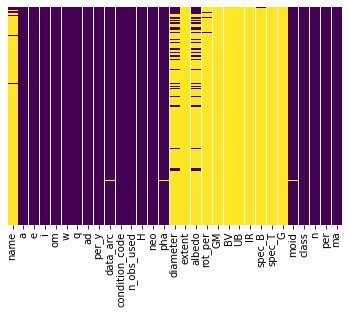

In [4]:
sns.heatmap(f.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [5]:
f=f.drop(['name','extent','rot_per','GM','BV','UB','IR','spec_B','spec_T','G'],axis=1)
f.drop(f[f['diameter'].isna()].index,inplace=True)

In [6]:
f.isna().sum()/f.shape[0]

a                 0.000000
e                 0.000000
i                 0.000000
om                0.000000
w                 0.000000
q                 0.000000
ad                0.000000
per_y             0.000000
data_arc          0.001003
condition_code    0.000000
n_obs_used        0.000000
H                 0.005427
neo               0.000000
pha               0.000000
diameter          0.000000
albedo            0.008937
moid              0.000000
class             0.000000
n                 0.000000
per               0.000000
ma                0.000000
dtype: float64

In [7]:
f.dtypes

a                 float64
e                 float64
i                 float64
om                float64
w                 float64
q                 float64
ad                float64
per_y             float64
data_arc          float64
condition_code     object
n_obs_used          int64
H                 float64
neo                object
pha                object
diameter           object
albedo            float64
moid              float64
class              object
n                 float64
per               float64
ma                float64
dtype: object

In [8]:
f['diameter']=f['diameter'].astype('float')

In [26]:
f['condition_code']=f['condition_code'].astype('float')

0

In [9]:
f['diameter'].map(type)

0         <class 'float'>
1         <class 'float'>
2         <class 'float'>
3         <class 'float'>
4         <class 'float'>
               ...       
797860    <class 'float'>
798077    <class 'float'>
798189    <class 'float'>
799752    <class 'float'>
810375    <class 'float'>
Name: diameter, Length: 137636, dtype: object

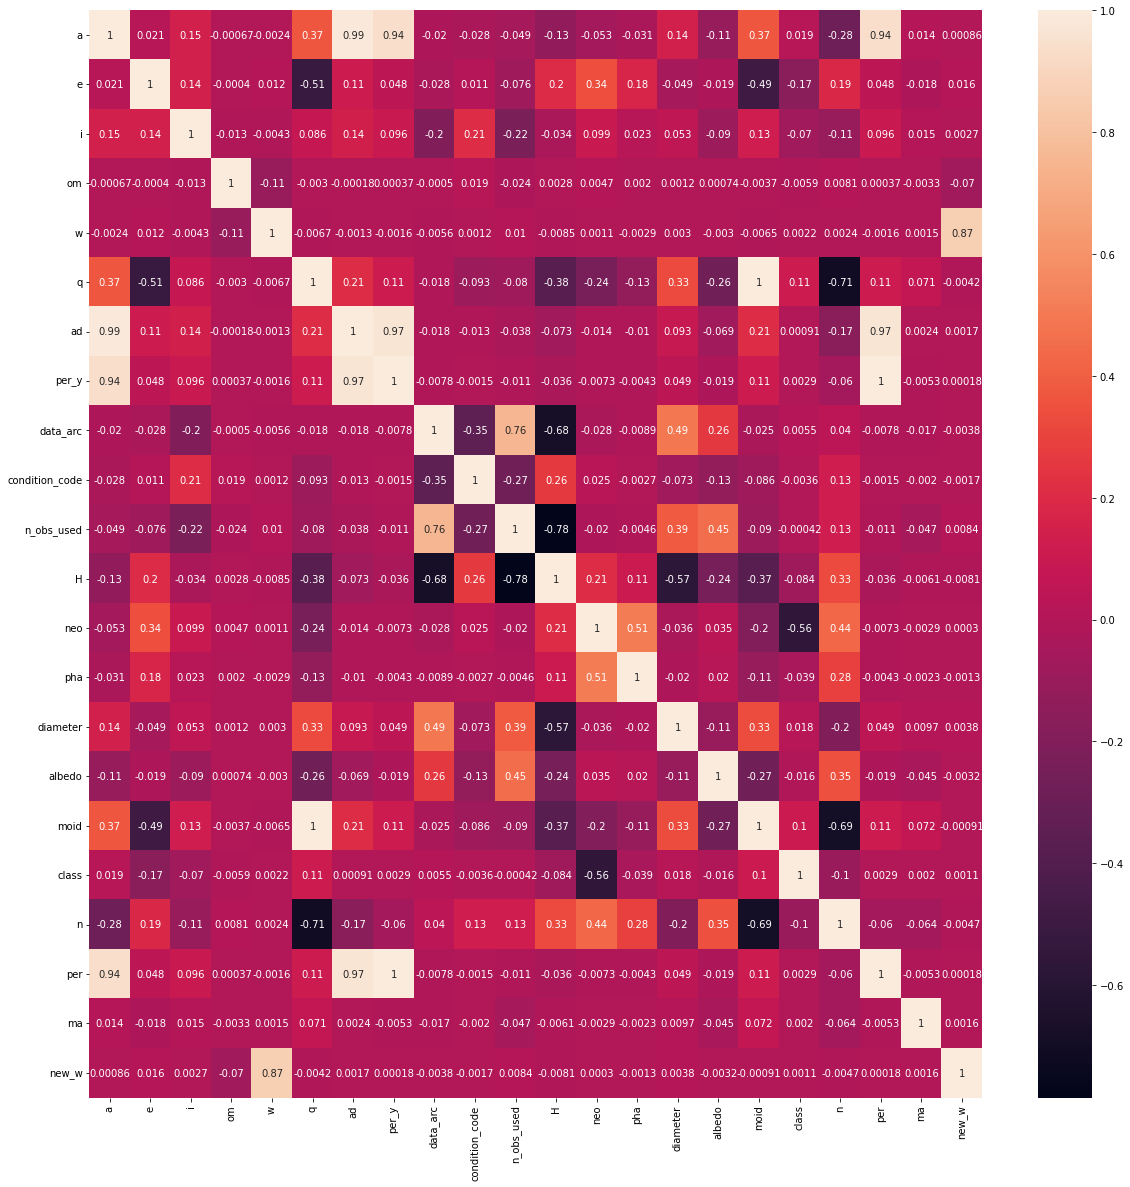

In [27]:
plt.figure(figsize=(20,20))
sns.heatmap(f.corr(), annot=True)

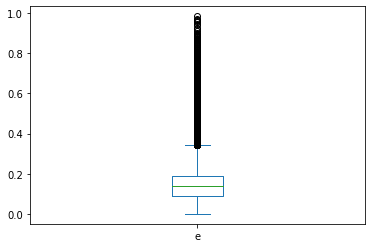

In [11]:
f.e.plot(kind="box")

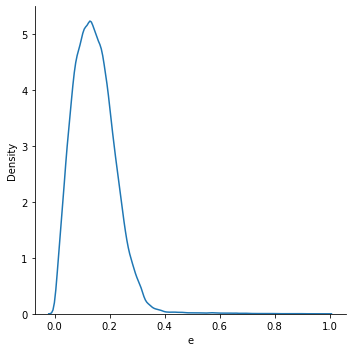

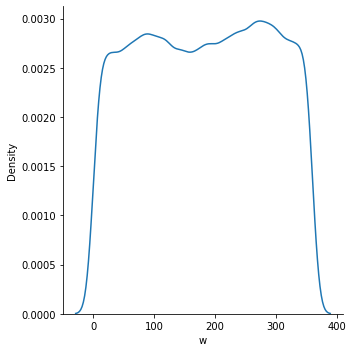

In [12]:
sns.displot(f,x='e',kind='kde')
sns.displot(f,x='w',kind='kde')

In [13]:
f=f.assign(new_w=lambda x: np.log(x.w))

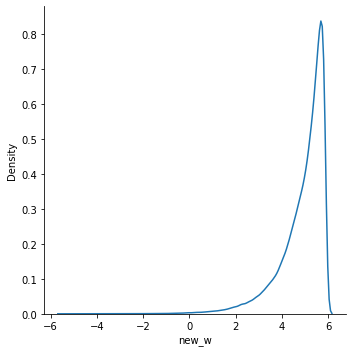

In [14]:
sns.displot(f,x='new_w',kind='kde')

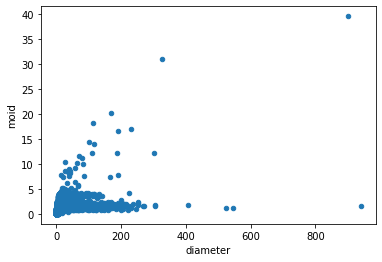

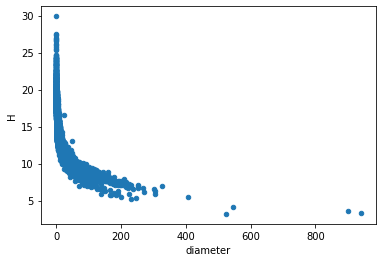

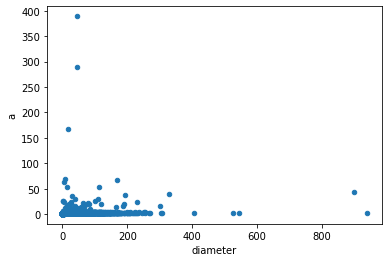

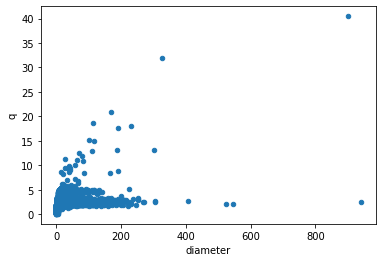

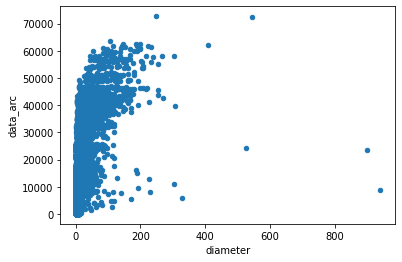

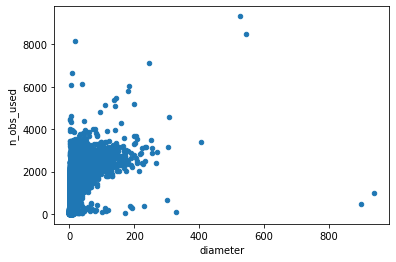

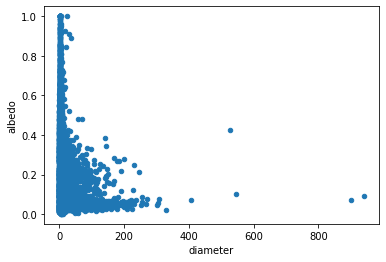

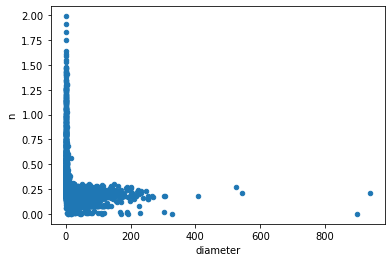

In [15]:
f.plot(kind = 'scatter', x = 'diameter', y = 'moid')
f.plot(kind = 'scatter', x = 'diameter', y = 'H')
f.plot(kind = 'scatter', x = 'diameter', y = 'a')
f.plot(kind = 'scatter', x = 'diameter', y = 'q')
f.plot(kind = 'scatter', x = 'diameter', y = 'data_arc')
f.plot(kind = 'scatter', x = 'diameter', y = 'n_obs_used')
f.plot(kind = 'scatter', x = 'diameter', y = 'albedo')
f.plot(kind = 'scatter', x = 'diameter', y = 'n')

In [16]:
f.dtypes

a                 float64
e                 float64
i                 float64
om                float64
w                 float64
q                 float64
ad                float64
per_y             float64
data_arc          float64
condition_code     object
n_obs_used          int64
H                 float64
neo                object
pha                object
diameter          float64
albedo            float64
moid              float64
class              object
n                 float64
per               float64
ma                float64
new_w             float64
dtype: object

In [17]:
o1=OneHotEncoder(sparse=False,handle_unknown='ignore')

0

In [25]:

f['neo']=o1.fit_transform(f[['neo']])
f['pha']=o1.fit_transform(f[['pha']])
f['class']=o1.fit_transform(f[['class']])

In [19]:
def objective(x,a,b):
  return a*x+b
#popt,_=curve_fit(objective,-np.log(f['diameter']),f['H'])
#a,b=popt
#print(a,b)

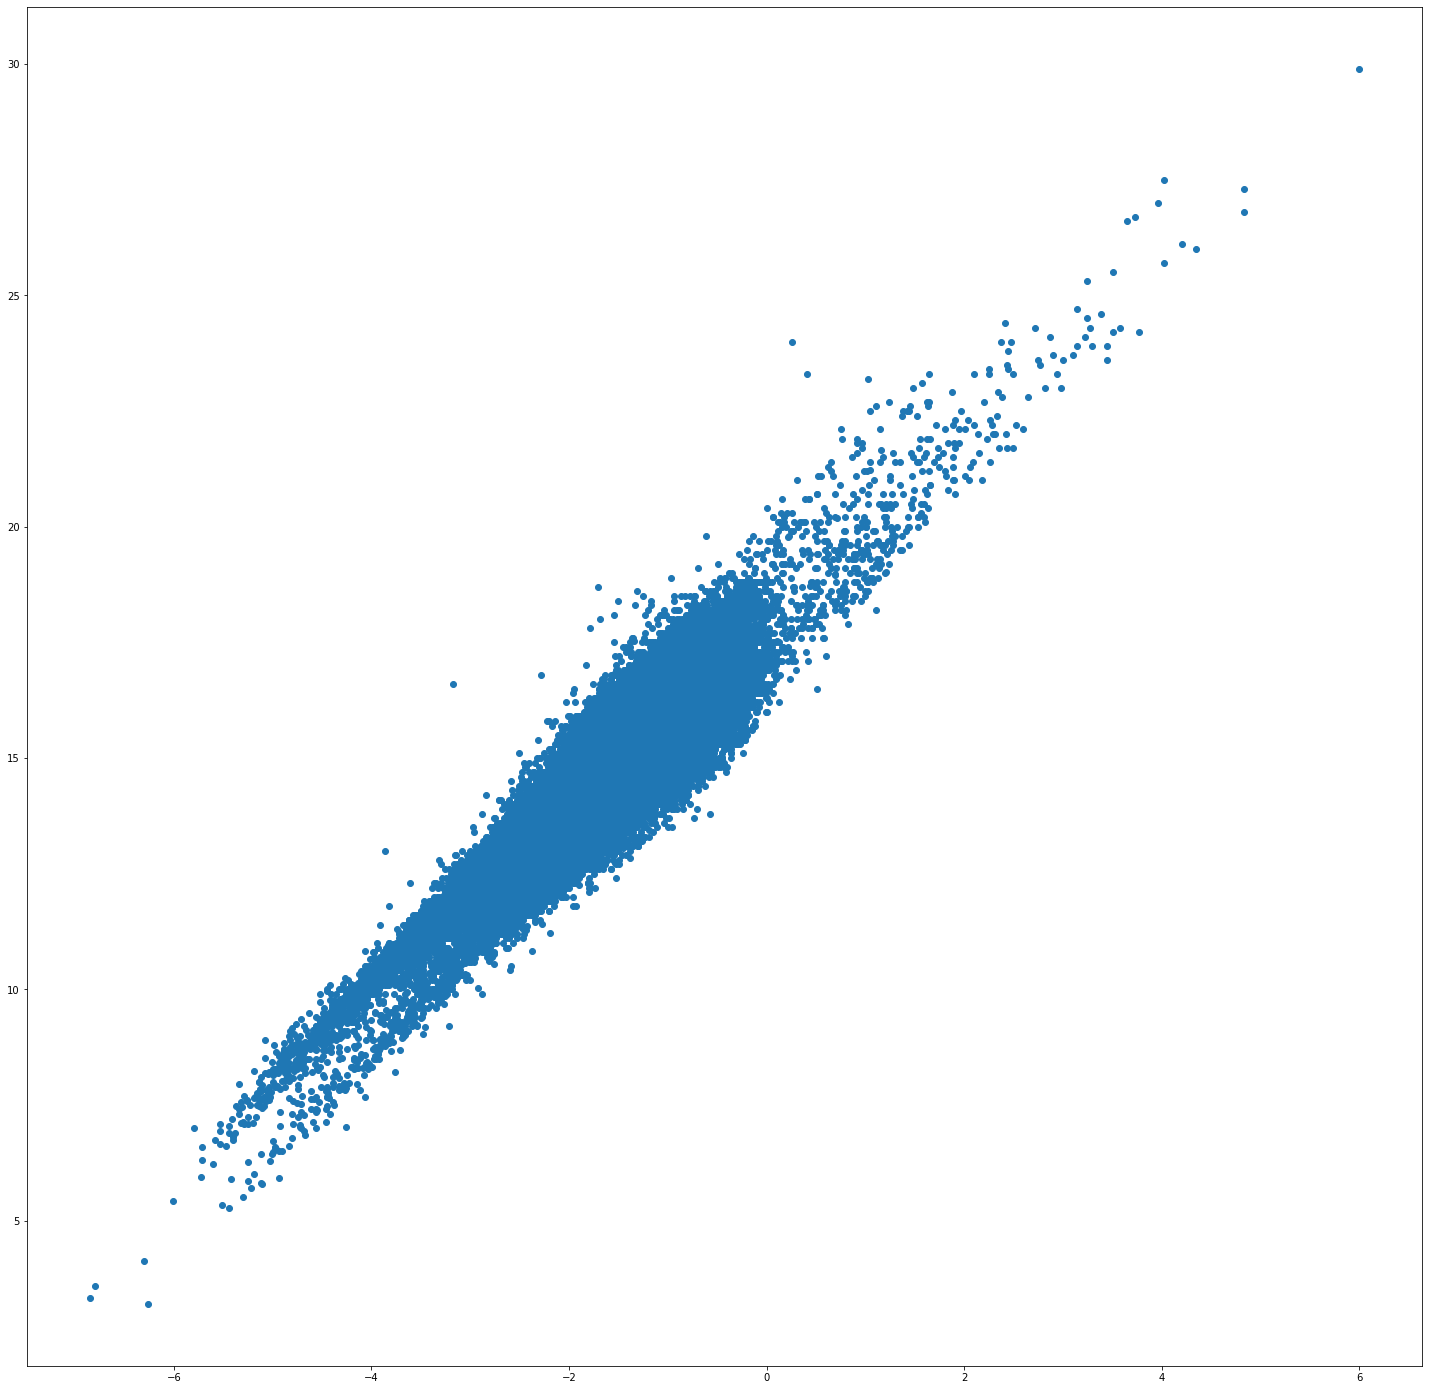

In [20]:
plt.figure(figsize=(25,25))
plt.scatter(-np.log(f['diameter']),f['H'])


In [21]:
#imp=KNNImputer(n_neighbors=8)
#nn_col=['a','e','i','om','w','q','ad','per_y','condition_code','n_obs_used','neo','pha','diameter','moid','class','n','per']
#nn_col.append('')

SyntaxError: ignored

In [28]:
f.isna().sum()/f.shape[0]

a                 0.000000
e                 0.000000
i                 0.000000
om                0.000000
w                 0.000000
q                 0.000000
ad                0.000000
per_y             0.000000
data_arc          0.001003
condition_code    0.000000
n_obs_used        0.000000
H                 0.005427
neo               0.000000
pha               0.000000
diameter          0.000000
albedo            0.008937
moid              0.000000
class             0.000000
n                 0.000000
per               0.000000
ma                0.000000
new_w             0.000000
dtype: float64

In [ ]:
#f=f.assign(new_H=lambda x: np.e**(-x.H))
#f.plot(kind = 'scatter', x = 'diameter', y = 'new_H')

S.No.  |Column Name     | Description
-------|----------------|------------
1.     |name            |Asteroid Name
2.     |a               |Semi Major Axis (au)
3.     |e               |Eccentricity
4.     |i               |Inclination with respect to x-y Ecliptic Plane (deg)
5.     |om              |Longitude of the Ascending Node
6.     |w               |Argument of Perihelion
7.     |q               |Perihelion Distance (au)
8.     |ad              |Aphelion Distance (au)
9.     |per_y           |Orbital Period (Years)
10.    |data_arc        |Data Arc-Span (d)
11.    |condition_code  |Orbit Condition Code
12.    |n_obs_used      |Number of Observation Used
13.    |H               |Absolute Magnitude Parameter
14.    |neo             |Near Earth Object
15.    |pha             |Physically Hazardous Asteroid
16.    |diameter        |Diameter of Asteroid (Km)
17.    |extent          |Object bi/tri-Axial Ellipsoid Dimensions(Km)
18.    |albedo          |Geometric Albedo
19.    |rot_per         |Rotation Period (h)
20.    |GM              |Standard Gravitational Parameter (Product of Mass and Gravitational Constant)
21.    |BV              |Color Index B-V Magnitude Difference
22.    |UB              |Color Index U-B Magnitude Difference
23.    |IR              |Color Index I-R Magnitude Difference
24.    |spec_B          |Spectral Taxonomic Type (SMASSII)
25.    |spec_T          |Spectral Taxonomic Type (Tholen)
26.    |G               |Magnitude Slope Parameter
27.    |moid            |Earth Minimum Orbit Intersection Distance (au)
28.    |class           |Asteroid Orbit Class
29.    |n               |Mean Motion (deg/d)
30.    |per             |Orbital Period (d)
31.    |ma              |Mean Anomaly (deg)